# Animal classification

## 0. Description

Let's make an application that identifies which animal appears in the picture given. We are going to get the data, train the model and put it into production.

## 1. Libraries

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier

import skimage

import tensorflow as tf
import tensorflow_hub as hub

## 2. Importing the data

### `2.1. Base case`

Veamos como se carga una sola imagen y se muestra en pantalla:

In [37]:
img=plt.imread('data/LionHead/lion007.jpg')
img.shape

(80, 80, 3)

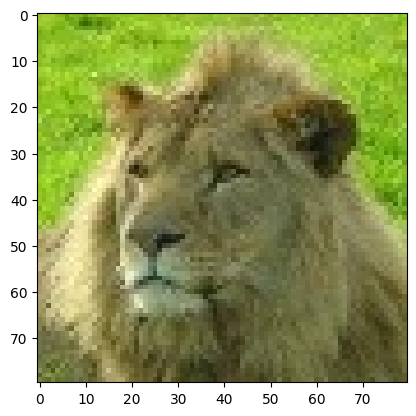

In [38]:
plt.imshow(img)

### `2.2. Real case`

Generamos dos listas, una con todas las imágenes cargadas con la ruta, y otra con las etiquetas, que serán las carpetas de nuestro directorio.

In [39]:
data=os.listdir('data')
img_list=[]
label_list=[]
for folder in data:
    for file in os.listdir('data/'+folder):
        if os.path.isfile('data/'+folder+'/'+file):
            img=plt.imread('data/'+folder+'/'+file)
            label_list.append(folder)
            img_list.append(img)

In [40]:
df=pd.DataFrame(data={"img":img_list,"label":label_list})
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 215,...",BearHead
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",BearHead
2,"[[[104, 109, 102], [105, 110, 103], [108, 115,...",BearHead
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",BearHead
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",BearHead


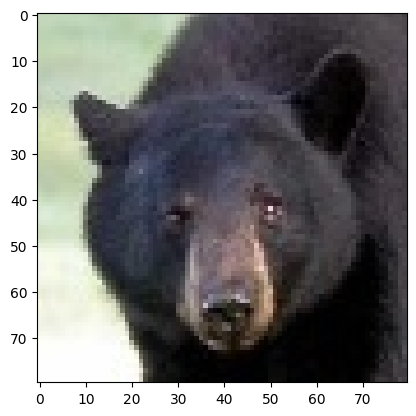

In [41]:
plt.imshow(df.loc[0,'img'])

### `2.3. Label names`

In [42]:
i=0
for word in df['label']:
    df.iloc[i,1]=word.replace('Head','')
    i+=1

In [43]:
df.label.unique()

array(['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle',
       'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Natural', 'Panda',
       'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf'], dtype=object)

In [44]:
df.shape

(2057, 2)

### `2.4. Trial`

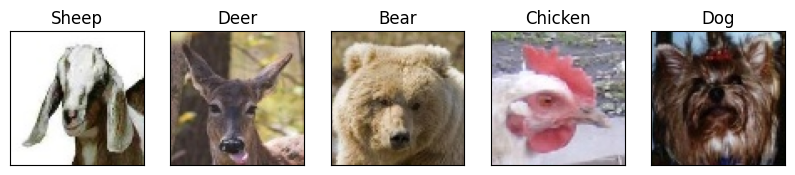

In [45]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,df.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(df.loc[j,'img'])
    plt.title(df.loc[j,'label'])

We can repeat this execution every time we want in order to check if the labels are right.

### `2.5. Data saving`

In [46]:
with open('pickle_files/diego_dataframe.pkl','wb') as f:
    pickle.dump(df,f)

## 3. Modeling

### `3.0. Label encoding`

In [47]:
df.head()

,img,label
0,"[[[196, 214, 188], [196, 214, 188], [196, 215,...",Bear
1,"[[[4, 2, 3], [7, 5, 6], [6, 5, 3], [5, 4, 2], ...",Bear
2,"[[[104, 109, 102], [105, 110, 103], [108, 115,...",Bear
3,"[[[124, 122, 123], [119, 117, 118], [116, 112,...",Bear
4,"[[[173, 182, 199], [174, 183, 200], [172, 181,...",Bear


In [48]:
dict_labels={}
i=0
for label in df.label.unique():
    dict_labels[label]=i
    i+=1
print(dict_labels)

{'Bear': 0, 'Cat': 1, 'Chicken': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Duck': 6, 'Eagle': 7, 'Elephant': 8, 'Human': 9, 'Lion': 10, 'Monkey': 11, 'Mouse': 12, 'Natural': 13, 'Panda': 14, 'Pigeon': 15, 'Rabbit': 16, 'Sheep': 17, 'Tiger': 18, 'Wolf': 19}


In [49]:
mapeo={}
for key in dict_labels.keys():
    mapeo[dict_labels[key]]=key
print(mapeo)

{0: 'Bear', 1: 'Cat', 2: 'Chicken', 3: 'Cow', 4: 'Deer', 5: 'Dog', 6: 'Duck', 7: 'Eagle', 8: 'Elephant', 9: 'Human', 10: 'Lion', 11: 'Monkey', 12: 'Mouse', 13: 'Natural', 14: 'Panda', 15: 'Pigeon', 16: 'Rabbit', 17: 'Sheep', 18: 'Tiger', 19: 'Wolf'}


Let's save the mapping

In [50]:
with open('pickle_files/diego_mapeo.pkl','wb') as f:
    pickle.dump(mapeo,f)

In [51]:
df["label_2"]=0

In [52]:
for i in range(df.shape[0]):
    df.iloc[i,2]=dict_labels[df.iloc[i,1]]
df.sample(5)

,img,label,label_2
169,"[[[216, 214, 189], [215, 213, 188], [221, 219,...",Cat,1
1239,"[[[143, 143, 31], [139, 139, 25], [144, 148, 2...",Monkey,11
237,"[[[27, 23, 22], [26, 25, 23], [22, 22, 22], [2...",Cat,1
261,"[[[35, 57, 21], [50, 69, 37], [41, 54, 26], [2...",Chicken,2
1610,"[[[50, 71, 38], [51, 72, 39], [55, 71, 44], [5...",Pigeon,15


In [53]:
df["label"]=df["label_2"]
df.drop(columns=["label_2"],inplace=True)
df.sample(5)

,img,label
503,"[[[131, 134, 31], [131, 134, 31], [142, 144, 4...",4
828,"[[[31, 27, 24], [41, 37, 34], [28, 24, 21], [1...",7
922,"[[[41, 50, 31], [49, 58, 37], [27, 32, 9], [58...",8
219,"[[[5, 6, 1], [2, 3, 0], [8, 4, 1], [6, 2, 0], ...",1
1807,"[[[38, 33, 40], [34, 29, 36], [33, 28, 34], [3...",17


### ``3.1. Data split``

In [54]:
x_train,x_test,y_train,y_test=train_test_split(df['img'],df['label'],test_size=0.2,random_state=42)

In [55]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645,), (412,), (1645,), (412,))

We need to change the format of the images.

In [56]:
x_train=np.array(x_train.tolist())
x_test=np.array(x_test.tolist())
x_train.shape,x_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3))

In [57]:
y_train

67       0
1001     9
567      5
1271    11
1666    16
        ..
1638    15
1095     9
1130    10
1294    11
860      7
Name: label, Length: 1645, dtype: int64

### `3.2. Encoding`

In [58]:
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)
type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray)

In [59]:
x_train=np.array(x_train/255)
x_test=np.array(x_test/255)
type(x_train),type(x_test)

(numpy.ndarray, numpy.ndarray)

In [60]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1645, 80, 80, 3), (412, 80, 80, 3), (1645,), (412,))

### ``3.3. Modeling and training``

#### First neural network (linear regression)

In [61]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [64]:
# history = model.fit(x_train,y_train,epochs=30, use_multiprocessing=False, verbose=False, validation_data=(x_test, y_test))
history = model.fit(x_train,y_train,epochs=30, verbose=False, validation_data=(x_test, y_test))
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8284 - loss: 0.4914
Training Accuracy: 0.8201


In [65]:
def training_plot( metricas, history):
    plt.figure(figsize=(10,3))
    for i,metrica in enumerate(metricas):
        plt.subplot(1,2,i+1)
        y = history.history[metrica]
        x = [ x+1 for x in range( len( history.history[metrica] ))]
        plt.plot(x,y)
        y = history.history[f'val_{metrica}']
        x = [ x+1 for x in range( len( history.history[f'val_{metrica}'] ))]
        plt.plot(x,y)
        plt.title(metrica)
        plt.legend([f'{metrica}',f'val_{metrica}'])

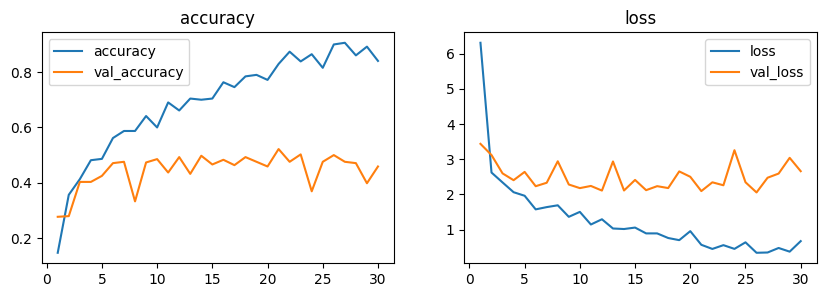

In [66]:
training_plot(['accuracy','loss'],history)

#### Let's define a new neural network now.

In [67]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [70]:
# history = model.fit(x_train,y_train,epochs=10, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=10, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.0767 - loss: 5.0018 - val_accuracy: 0.0995 - val_loss: 3.4018
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.1709 - loss: 2.9815 - val_accuracy: 0.1893 - val_loss: 2.5890
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.2182 - loss: 2.5941 - val_accuracy: 0.2937 - val_loss: 2.4096
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.3019 - loss: 2.3740 - val_accuracy: 0.3350 - val_loss: 2.2839
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.3652 - loss: 2.2201 - val_accuracy: 0.3786 - val_loss: 2.1908
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.3891 - loss: 2.0800 - val_accuracy: 0.4272 - val_loss: 2.0710
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.4250 - loss: 2.0262 - val_accuracy: 0.4369 - val_loss: 2.0391
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.4606 - loss: 1.9772 - val_accuracy: 0.

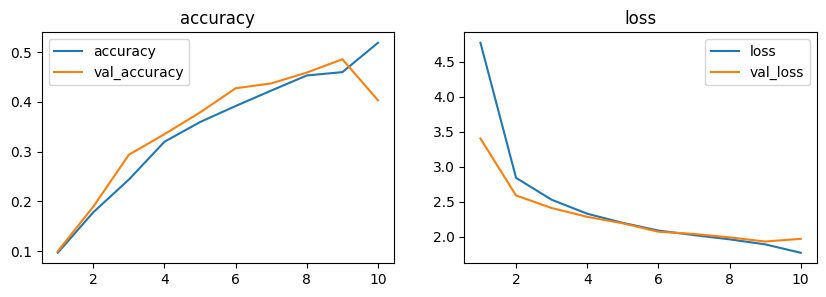

In [71]:
training_plot(['accuracy','loss'],history)

#### Deep neural network (more than one hidden layer)

In [72]:
layers=[]
layers.append(tf.keras.layers.Flatten(input_shape=(80,80,3)))
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [75]:
# history = model.fit(x_train,y_train,epochs=20, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=20, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.1032 - loss: 3.2850 - val_accuracy: 0.1772 - val_loss: 2.6932
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - accuracy: 0.1844 - loss: 2.7666 - val_accuracy: 0.2743 - val_loss: 2.5221
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.2332 - loss: 2.5511 - val_accuracy: 0.3204 - val_loss: 2.3581
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.2979 - loss: 2.3569 - val_accuracy: 0.3689 - val_loss: 2.2368
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 272ms/step - accuracy: 0.3297 - loss: 2.2337 - val_accuracy: 0.3859 - val_loss: 2.1236
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.3704 - loss: 2.1601 - val_accuracy: 0.4150 - val_loss: 2.0476
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.3904 - loss: 2.0852 - val_accuracy: 0.4442 - val_loss: 1.9795
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.4388 - loss: 1.9437 - val_accuracy: 0.

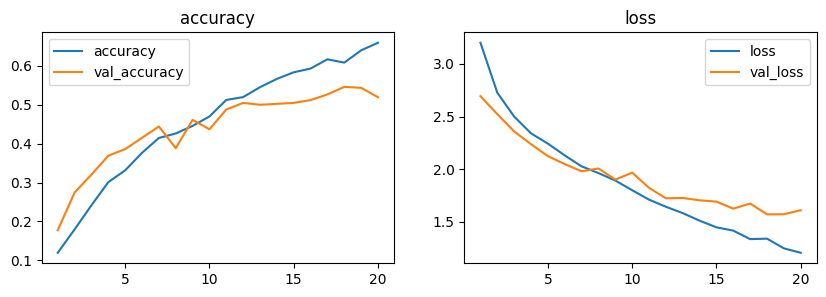

In [76]:
training_plot(['accuracy','loss'],history)

#### Convolutional neural network

In [77]:
layers=[]

layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(80,80,3)))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))
layers.append(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D((2,2)))

layers.append(tf.keras.layers.Flatten())
layers.append(tf.keras.layers.Dense(1500,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(1000,activation='relu'))
layers.append(tf.keras.layers.Dropout(0.2))
layers.append(tf.keras.layers.Dense(20,activation='softmax'))

model=tf.keras.Sequential(layers)

c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [78]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [79]:
# history = model.fit(x_train,y_train,epochs=20, use_multiprocessing=False, validation_data=(x_test, y_test), batch_size=128)
history = model.fit(x_train,y_train,epochs=20, validation_data=(x_test, y_test), batch_size=128)
print('Training Accuracy: {:.4f}'.format(model.evaluate(x_train,y_train)[1]))

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 696ms/step - accuracy: 0.0776 - loss: 2.9418 - val_accuracy: 0.2063 - val_loss: 2.7967
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 645ms/step - accuracy: 0.1816 - loss: 2.7377 - val_accuracy: 0.2573 - val_loss: 2.5097
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 616ms/step - accuracy: 0.3094 - loss: 2.3988 - val_accuracy: 0.3325 - val_loss: 2.1975
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step - accuracy: 0.3733 - loss: 2.1158 - val_accuracy: 0.4345 - val_loss: 2.0217
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 650ms/step - accuracy: 0.4880 - loss: 1.8621 - val_accuracy: 0.4733 - val_loss: 1.7914
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 715ms/step - accuracy: 0.5139 - loss: 1.6941 - val_accuracy: 0.5704 - val_loss: 1.5482
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - accuracy: 0.5849 - loss: 1.4073 - val_accuracy: 0.6019 - val_loss: 1.3944
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 626ms/step - accuracy: 0.6337 - loss: 1.2765 - val_accuracy: 0

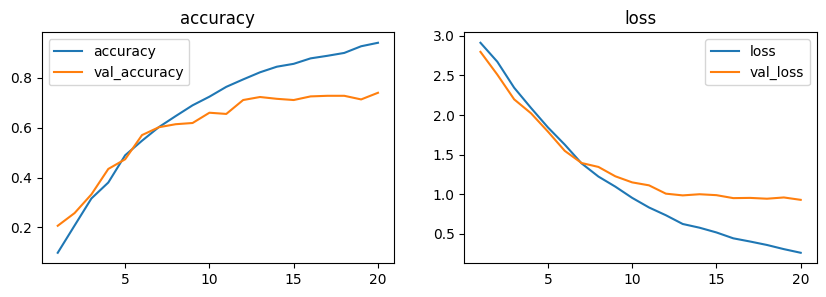

In [80]:
training_plot(['accuracy','loss'],history)

Let's save the model

In [81]:
model.save('model/model.h5')

## 4. Testing

### `4.1. Simple testing`

In [ ]:
predictions=model.predict(x_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


In [83]:
predictions.shape

(412, 20)

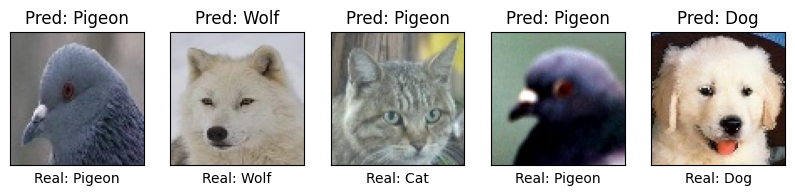

In [124]:
fig,ax=plt.subplots(1,5,figsize=(10,4))
for i in range(5):
    j=np.random.randint(0,x_test.shape[0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[j])
    plt.title(f'Pred: {mapeo[np.argmax(predictions[j])]}')
    plt.xlabel(f'Real: {mapeo[y_test[j]]}')
plt.show()

In [85]:
print(f'Accuracy: {np.sum(np.argmax(predictions,axis=1)==y_test)/y_test.shape[0]}')
print(f'Error: {np.sum(np.argmax(predictions,axis=1)!=y_test)/y_test.shape[0]}')

Accuracy: 0.7402912621359223
Error: 0.25970873786407767


In [86]:
df_pred=pd.DataFrame(data={'pred':np.argmax(predictions,axis=1),'real':y_test})
df_pred.head()

,pred,real
0,10,1
1,18,18
2,1,1
3,10,10
4,14,14


In [87]:
df_pred["real"]=df_pred["real"].apply(lambda x: mapeo[x])
df_pred["pred"]=df_pred["pred"].apply(lambda x: mapeo[x])

In [88]:
df_pred.head()

,pred,real
0,Lion,Cat
1,Tiger,Tiger
2,Cat,Cat
3,Lion,Lion
4,Panda,Panda


In [89]:
df_pred["exito"]=(df_pred["real"]==df_pred["pred"]).astype(int)

In [90]:
df_pred.exito.value_counts()

exito
1    305
0    107
Name: count, dtype: int64

Let's see it in a confussion matrix, which shows how many predictions there were for each label

In [91]:
pd.crosstab(df_pred['real'],df_pred['pred'],margins=True)

pred,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf,All
real,,,,,,,,,,,,,,,,,,,,
Bear,15,0,0,1,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,20
Cat,1,21,0,0,1,0,0,0,0,0,1,1,2,0,3,1,0,0,2,33
Chicken,0,0,24,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,25
Cow,0,0,0,14,1,2,0,0,1,0,0,1,1,0,0,0,2,0,0,22
Deer,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,23
Dog,0,1,1,1,0,17,1,0,1,0,0,0,1,0,0,1,0,0,0,24
Duck,0,1,0,0,0,0,13,0,0,0,0,2,3,0,1,0,0,0,0,20
Eagle,0,0,0,0,0,0,1,10,0,0,0,0,1,1,5,1,0,0,0,19
Elephant,1,0,0,0,0,2,0,0,19,0,0,0,0,0,0,0,2,0,1,25


In [92]:
import sklearn.metrics as metrics

In [93]:
pd.DataFrame(metrics.classification_report(df_pred['real'],df_pred['pred'],output_dict=True)).T.sort_values(by='f1-score',ascending=False)

c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\diego\Documents\GitHub\Animal-Classification-App\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

,precision,recall,f1-score,support
Chicken,0.960000,0.960000,0.960000,25.000000
Human,0.950000,0.950000,0.950000,20.000000
Panda,0.944444,0.944444,0.944444,18.000000
Deer,0.916667,0.956522,0.936170,23.000000
Tiger,0.789474,0.882353,0.833333,17.000000
Wolf,0.869565,0.769231,0.816327,26.000000
Elephant,0.863636,0.760000,0.808511,25.000000
Cat,0.913043,0.636364,0.750000,33.000000
weighted avg,0.766050,0.740291,0.742295,412.000000
accuracy,0.740291,0.740291,0.740291,0.740291


In [94]:
pd.options.display.float_format = '{:.4f}'.format
df_proba=pd.DataFrame(predictions,columns=[mapeo[i] for i in range(20)])
df_proba

,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Natural,Panda,Pigeon,Rabbit,Sheep,Tiger,Wolf
0,0.0149,0.0050,0.0018,0.0101,0.0041,0.1272,0.0227,0.0086,0.1407,0.0165,0.2289,0.0312,0.1304,0.0256,0.0000,0.0182,0.0807,0.0042,0.0334,0.0959
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9999,0.0000
2,0.0008,0.9662,0.0000,0.0000,0.0000,0.0000,0.0000,0.0014,0.0000,0.0000,0.0001,0.0000,0.0205,0.0002,0.0079,0.0000,0.0013,0.0013,0.0000,0.0001
3,0.0012,0.0001,0.0006,0.0004,0.0001,0.0027,0.0008,0.0004,0.0012,0.0012,0.9861,0.0025,0.0003,0.0006,0.0001,0.0001,0.0006,0.0001,0.0009,0.0000
4,0.0010,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9990,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.0355,0.0001,0.0000,0.0065,0.0037,0.0243,0.0015,0.0004,0.0273,0.0001,0.0626,0.7142,0.0127,0.0028,0.0001,0.0718,0.0123,0.0022,0.0182,0.0038
408,0.0001,0.0000,0.9952,0.0002,0.0001,0.0002,0.0001,0.0001,0.0000,0.0004,0.0001,0.0008,0.0023,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000
409,0.0056,0.0001,0.0001,0.0014,0.0004,0.0007,0.0000,0.0000,0.0004,0.0000,0.9348,0.0524,0.0001,0.0013,0.0004,0.0000,0.0000,0.0000,0.0007,0.0016
410,0.0042,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.9956,0.0000,0.0000,0.0000,0.0000,0.0000


### `4.2. Bear or not`

Let's analyse it as a binary classification problem (bear or not) 

In [95]:
y_test_s=pd.Series(y_test)
y_test_s=y_test_s.apply(lambda x: mapeo[x])
y_test_s

0          Cat
1        Tiger
2          Cat
3         Lion
4        Panda
        ...   
407     Monkey
408    Chicken
409       Lion
410      Panda
411      Mouse
Length: 412, dtype: object

In [96]:
y_test_s=(y_test_s=="Bear").astype(int)
y_test_s

0      0
1      0
2      0
3      0
4      0
      ..
407    0
408    0
409    0
410    0
411    0
Length: 412, dtype: int64

In [97]:
y_test_s.value_counts()

0    392
1     20
Name: count, dtype: int64

C:\Users\diego\AppData\Local\Temp\ipykernel_7520\882954125.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
C:\Users\diego\AppData\Local\Temp\ipykernel_7520\882954125.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1],'r--',color='blue')


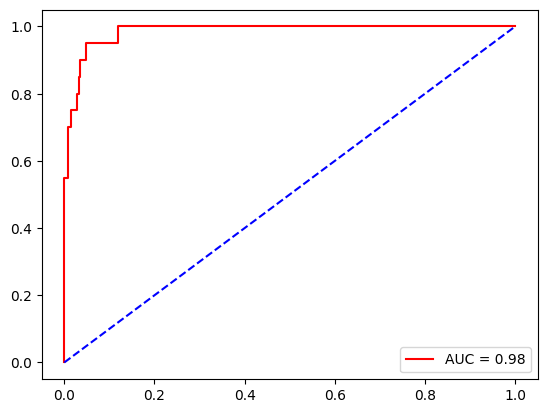

In [98]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_s, df_proba['Bear'])
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,color='red')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--',color='blue')

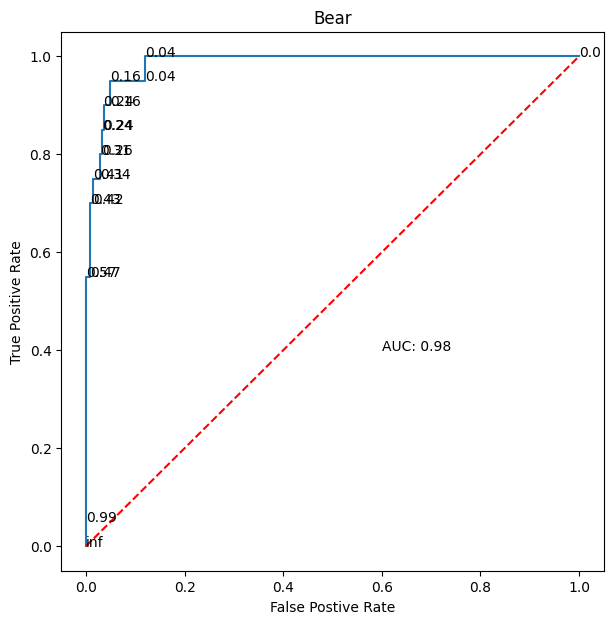

In [99]:
plt.figure(figsize=(7,7))
fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba['Bear'] )
metrica_auc = metrics.auc(fpr, tpr)
plt.plot( fpr, tpr ) 
plt.plot([0,1],[0,1], color='Red', linestyle='--')
plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.6,0.4])
plt.title('Bear')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
for x in range( len(_)):
    plt.annotate( round(_[x],2), [ fpr[x], tpr[x] ])

In [100]:
np.round(_*100,2)

array([  inf, 98.52, 56.51, 46.78, 43.14, 42.33, 41.14, 33.84, 31.16,
       25.54, 24.43, 24.34, 24.26, 16.09, 15.58,  3.72,  3.64,  0.  ],
      dtype=float32)

Let's set a threshold of 30%.

In [101]:
y_pred_s_30=(df_proba['Bear']>0.3).astype(int)
y_pred_s_30.value_counts()

Bear
0    385
1     27
Name: count, dtype: int64

In [102]:
y_test_s_30=(y_test_s==1).astype(int)
y_test_s_30.value_counts()

0    392
1     20
Name: count, dtype: int64

In [103]:
pd.crosstab(y_test_s,y_pred_s_30, margins= True )

Bear,0,1,All
row_0,,,
0,381,11,392
1,4,16,20
All,385,27,412


In [104]:
print(f'The accuracy of the model is: {metrics.accuracy_score(y_test_s,y_pred_s_30)}')
print(f'The precision of the model is: {metrics.precision_score(y_test_s,y_pred_s_30)}')
print(f'The recall of the model is: {metrics.recall_score(y_test_s,y_pred_s_30)}')

The accuracy of the model is: 0.9635922330097088
The precision of the model is: 0.5925925925925926
The recall of the model is: 0.8


### `4.3. For all labels`

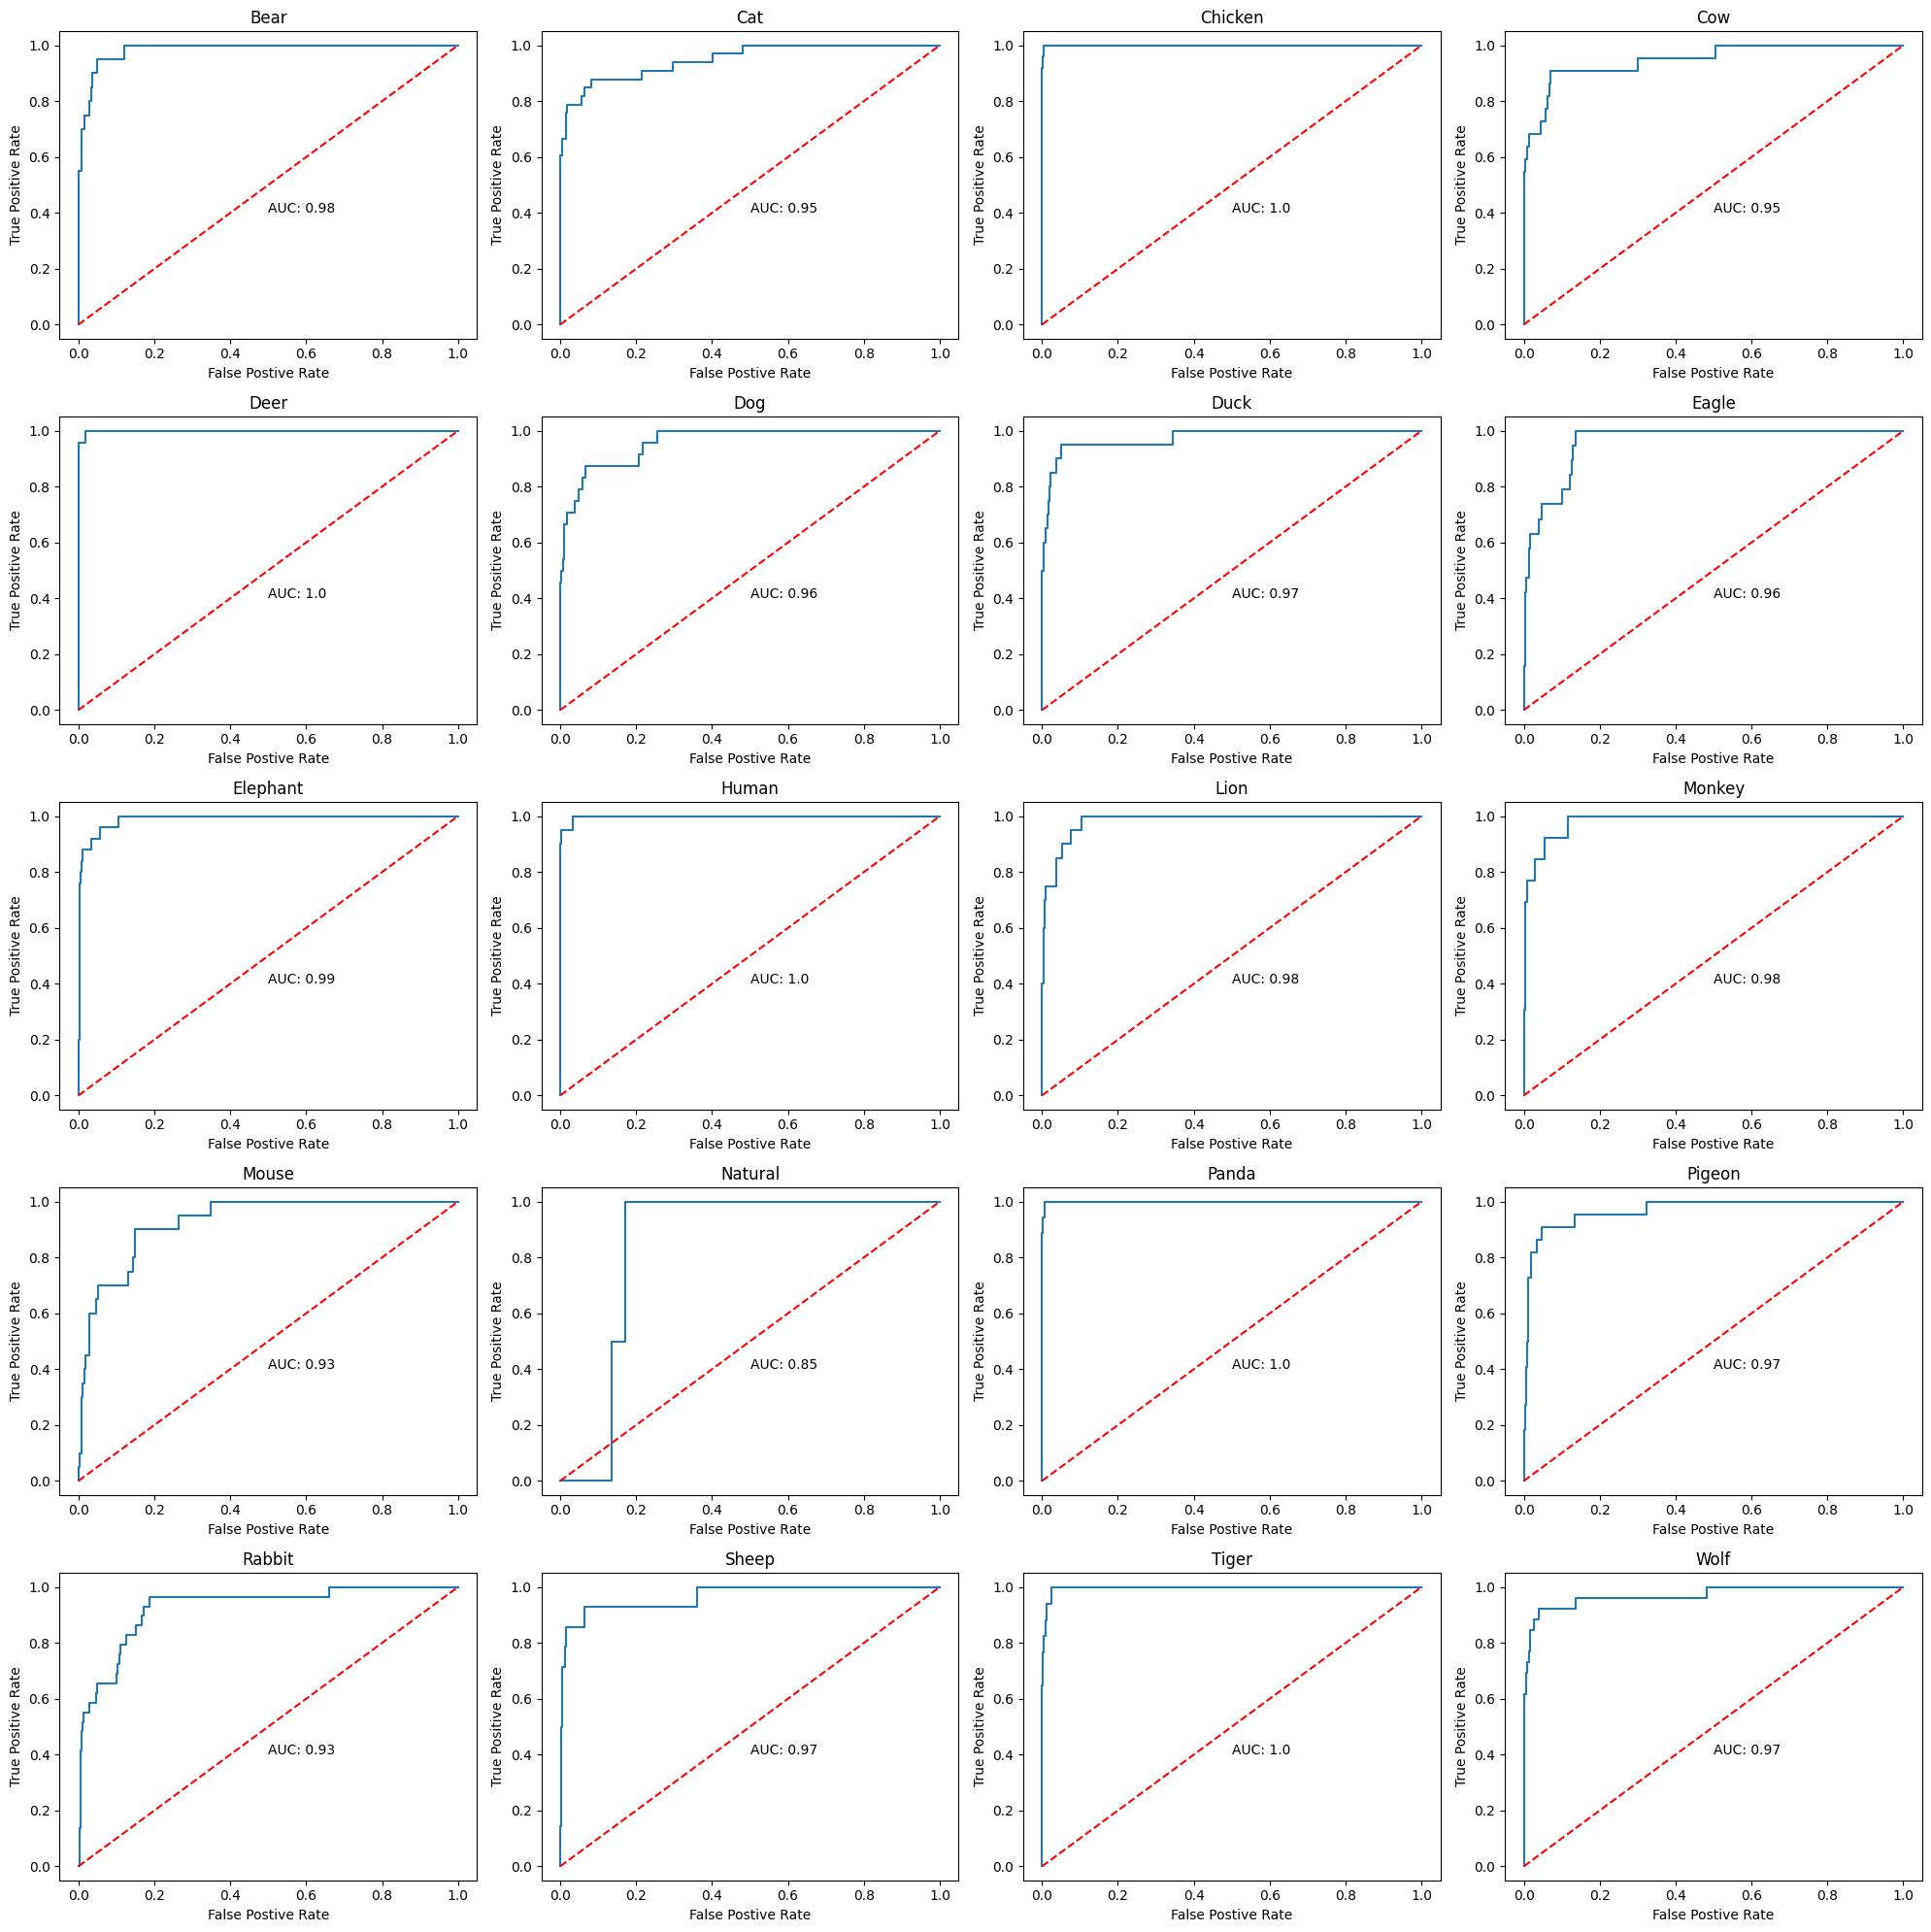

In [105]:
plt.figure(figsize=(20,20))
for i,clase in enumerate(mapeo.values()):
    plt.subplot(5,4,i+1)
    y_test_s=pd.Series(y_test)
    y_test_s=y_test_s.apply(lambda x: mapeo[x])
    y_test_s=(y_test_s==clase).astype(int)
    fpr, tpr, _ = metrics.roc_curve(y_test_s, df_proba[clase] )
    metrica_auc = metrics.auc(fpr, tpr)
    plt.plot( fpr, tpr ) 
    plt.plot([0,1],[0,1], color='Red', linestyle='--')
    plt.annotate(f'AUC: { round(metrica_auc,2)}', [0.5,0.4])
    plt.title(clase)
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
plt.tight_layout()

### ``4.4. Other images prediction``

We have some other images in the folde Images. Let's see if our model can identify them correctly.

In [106]:
def model_pipeline(file_path,mapping,model):
    img_path=file_path
    img=plt.imread(img_path)
    img=skimage.transform.resize(img,(80,80,3))
    img=np.array(img)
    predict=model.predict(img.reshape(1,80,80,3),verbose=False)
    results_s=(pd.Series(predict[0],index=[mapping[i] for i in range(20)]).sort_values(ascending=False)[:5]*100).to_dict()
    for key in results_s:
        results_s[key]=round(results_s[key],2)
    return results_s

In [107]:
model_pipeline('Images/eagle.jpg',mapeo,model)

{'Eagle': 97.74, 'Panda': 0.78, 'Tiger': 0.28, 'Duck': 0.27, 'Wolf': 0.23}

In [108]:
model_pipeline('Images/lion.jpg',mapeo,model)

{'Duck': 45.88, 'Chicken': 33.99, 'Monkey': 13.75, 'Human': 4.53, 'Mouse': 0.6}

In [109]:
model_pipeline('Images/dog_test.jpg',mapeo,model)

{'Monkey': 42.13,
 'Mouse': 29.08,
 'Chicken': 16.88,
 'Rabbit': 3.76,
 'Deer': 2.12}

## 5. Transfer Learning

In order to get higher accuracy, let's upload a better model from tensorflow and combine it with our data and prediction settings.

It is better to upload the model instead of calling your web address because we do not know if the server might crash or not.

We are uploading the images again because we need to reshape them to 224x224.

In [110]:
IMG_WEIGHT=224
IMG_WIDTH=224
IMG_CHANNELS=3
def read_and_decode(filename,reshape_dims):
    img=tf.io.read_file(filename)
    img=tf.image.decode_jpeg(img,channels=IMG_CHANNELS)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return tf.image.resize(img,reshape_dims)

In [111]:
file_list=['data/'+path+'/'+file for path in os.listdir('data') for file in os.listdir ('data/'+path)]
len(file_list)

2057

In [112]:
img=read_and_decode(file_list[0],[IMG_WEIGHT,IMG_WIDTH])
img.shape

TensorShape([224, 224, 3])

In [113]:
img_tf=[read_and_decode(file,[IMG_WEIGHT,IMG_WIDTH]) for file in file_list]
img_np=np.array(img_tf)
img_np.shape

(2057, 224, 224, 3)

In [114]:
target=[img[img.find('/')+1:img.rfind('/')-4] for img in file_list]
len(target)

2057

In [115]:
x=img_np
y=target

In [116]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

NameError: name 'X' is not defined

In [338]:
encoder=LabelEncoder()
encoder.fit(y_train)

y_train=encoder.transform(y_train)
y_test=encoder.transform(y_test)

In [339]:
def training_plot(metrics,history):
    f,ax=plt.subplots(1,len(metrics),figsize=(10,3))
    for idx,metric in enumerate(['loss','accuracy']):
        ax[idx].plot([x for x in range(1,len(history.history[metric])+1)],history.history[metric])
        ax[idx].plot([ x for x in range(1,len(history.history[f'val_{metric}'])+1)],history.history[f'val_{metric}'])
        ax[idx].legend([metric, f'val_{metric}'],fontsize=9)

In [340]:
layers=[]
layers.append(hub.KerasLayer('./keras_layer', input_shape=(224,224,3),trainable=False,name='mobilenet_embedding'))

layers.append(tf.keras.layers.Dense(500,activation='relu',name='H1_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(200,activation='relu',name='H2_layer'))
layers.append(tf.keras.layers.Dropout(0.20))
layers.append(tf.keras.layers.Dense(20,activation='softmax',name='Clasification_layer'))

model=tf.keras.Sequential(layers)

In [341]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [342]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 H1_layer (Dense)            (None, 500)               640500    
                                                                 
 dropout_25 (Dropout)        (None, 500)               0         
                                                                 
 H2_layer (Dense)            (None, 200)               100200    
                                                                 
 dropout_26 (Dropout)        (None, 200)               0         
                                                                 
 Clasification_layer (Dense)  (None, 20)               4020      
                                                     

In [343]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10


26/26 [==============================] - 37s 1s/step - loss: 1.0835 - accuracy: 0.6954 - val_loss: 0.2224 - val_accuracy: 0.9296
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 0.2042 - accuracy: 0.9374 - val_loss: 0.1713 - val_accuracy: 0.9539
Epoch 3/10
26/26 [==============================] - 22s 842ms/step - loss: 0.1183 - accuracy: 0.9623 - val_loss: 0.1669 - val_accuracy: 0.9393
Epoch 4/10
26/26 [==============================] - 21s 819ms/step - loss: 0.0695 - accuracy: 0.9781 - val_loss: 0.1386 - val_accuracy: 0.9587
Epoch 5/10
26/26 [==============================] - 18s 707ms/step - loss: 0.0424 - accuracy: 0.9884 - val_loss: 0.0973 - val_accuracy: 0.9684
Epoch 6/10
26/26 [==============================] - 19s 742ms/step - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.1609 - val_accuracy: 0.9563
Epoch 7/10
26/26 [==============================] - 21s 811ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.1530 - val_accuracy: 0.9490
Epoch 8/10
26/26

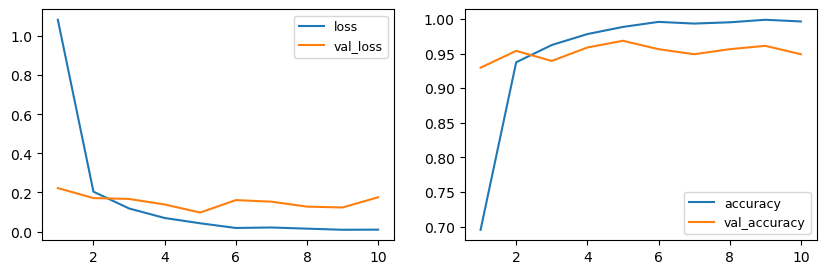

In [344]:
training_plot(['loss','accuracy'],history)

We are going to save the model.

In [345]:
model.save('model/model_tf.h5')